In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import os
import json

import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import models.vqvae as vqvae
import utils.losses as losses 
import options.option_vq as option_vq
import utils.utils_model as utils_model
from dataset import dataset_VQ, dataset_TM_eval
import utils.eval_trans as eval_trans
from options.get_eval_option import get_opt
from models.evaluator_wrapper import EvaluatorModelWrapper
import warnings
warnings.filterwarnings('ignore')
from utils.word_vectorizer import WordVectorizer
from tqdm import tqdm
from exit.utils import get_model, visualize_2motions

In [2]:
class Temp:
    def __init__(self):
        print('mock:: opt')
args = Temp()
args.dataname = args.dataset_name = 't2m'
w_vectorizer = WordVectorizer('./glove', 'our_vab')

if args.dataname == 'kit' : 
    dataset_opt_path = './checkpoints/kit/Comp_v6_KLD005/opt.txt'  
    args.nb_joints = 21
else :
    dataset_opt_path = './checkpoints/t2m/Comp_v6_KLD005/opt.txt'
    args.nb_joints = 22
wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)

mock:: opt
Reading ./checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading Evaluation Model Wrapper (Epoch 28) Completed!!


In [3]:
args.batch_size = 256
args.down_t = 2
args.window_size = 64
train_loader = dataset_VQ.DATALoader(args.dataname,
                                        args.batch_size,
                                        window_size=args.window_size,
                                        unit_length=2**args.down_t)
train_loader_iter = dataset_VQ.cycle(train_loader)

  0%|          | 0/23384 [00:00<?, ?it/s]

100%|██████████| 23384/23384 [00:08<00:00, 2902.69it/s]

Total number of motions 20942


In [4]:
args.nb_code = 8192 #512 # 4096 # 
args.code_dim = 32 #512 # 512 # 
args.output_emb_width = 512
args.down_t = 2
args.stride_t = 2
args.width = 512
args.depth = 3
args.dilation_growth_rate = 3
args.vq_act = 'relu'
args.vq_norm = None

args.quantizer = 'ema_reset'
args.mu = 0.99
net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate,
                       args.vq_act,
                       args.vq_norm)
# args.resume_pth = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/11_VQVAE_1token_4096_trans_2lyr/net_last.pth'
args.resume_pth = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/2023-07-19-04-17-17_12_VQVAE_20batchResetNRandom_8192_32/net_last.pth'
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
# net = torch.nn.DataParallel(net)
net.train()
net.cuda()

args.recons_loss = 'l1_smooth'
args.nb_joints
Loss = losses.ReConsLoss(args.recons_loss, args.nb_joints)

In [5]:
# input_emb_width: 263 output_emb_width: 32 down_t: 2 stride_t: 2
# width: 512 depth: 3 dilation_growth_rate: 3 activation: relu norm: None
class DepthwiseSeparableConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = torch.nn.Conv1d(
            in_channels, in_channels, kernel_size=kernel_size, padding=padding, dilation=dilation, groups=in_channels)
        self.pointwise = torch.nn.Conv1d(
            in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [6]:
#### DEBUG 
conv = torch.nn.Conv1d(in_channels=251, out_channels=512, 
                       kernel_size=3, 
                       stride=1, 
                       padding=0)
conv = DepthwiseSeparableConv(in_channels=251, out_channels=512, 
                       kernel_size=3, padding=2, dilation=2)
conv(torch.rand(2, 251, 64)).shape


torch.Size([2, 512, 64])

In [64]:
gt_motion = next(train_loader_iter)
gt_motion.shape

torch.Size([256, 64, 263])

In [65]:
padding = 0
dilation = 1
n_in = n_state = 512
conv1 = torch.nn.Conv1d(n_in, n_state, 3, 1, padding, dilation)
x = torch.rand(256, 512, 64)
conv1(x).shape

torch.Size([256, 512, 62])

In [66]:
args.commit = 0.02
args.loss_vel = 0.5

gt_motion = next(train_loader_iter)
gt_motion = gt_motion.cuda().float() # (bs, 64, dim)

pred_motion, loss_commit, perplexity = net(gt_motion)
loss_motion = Loss(pred_motion, gt_motion)
loss_vel = Loss.forward_joint(pred_motion, gt_motion)

loss = loss_motion + args.commit * loss_commit + args.loss_vel * loss_vel

In [10]:
loss_motion, loss_commit, loss_vel

(tensor(0.0628, device='cuda:0', grad_fn=<SmoothL1LossBackward>),
 tensor(3.0207e-06, device='cuda:0', grad_fn=<MseLossBackward>),
 tensor(0.0225, device='cuda:0', grad_fn=<SmoothL1LossBackward>))

### Distance Codebook

In [9]:
codebook = net.vqvae.quantizer.codebook

x = codebook
k_w = codebook.t()
distance = torch.sum(x ** 2, dim=-1, keepdim=True) - 2 * torch.matmul(x, k_w) + torch.sum(k_w ** 2, dim=0, keepdim=True)
distance = torch.sqrt(distance.clamp(min=1e-8))
distance.max(-1).values.mean(), distance.min(-1).values.mean()
# (distance[0] < 1).sum()
(distance[torch.eye(distance.shape[0]) != 1] < 5).sum()

# rm self position
d_rm_self = distance[torch.eye(distance.shape[0]) != 1].reshape(8192, -1)
d_rm_self.max(-1).values.mean(), d_rm_self.min(-1).values.mean()
# d_rm_self.std(-1).mean()

(tensor(131.3641, device='cuda:0'), tensor(0.0133, device='cuda:0'))

### VQVAE Upper Lower


In [30]:
from models.vqvae_sep import VQVAE_SEP
vqvae_sep = VQVAE_SEP(args, ## use args to define different parameters in different quantizers
                args.nb_code,
                args.code_dim,
                args.output_emb_width,
                args.down_t,
                args.stride_t,
                args.width,
                args.depth,
                args.dilation_growth_rate,
                args.vq_act,
                args.vq_norm,
                {'mean': torch.from_numpy(train_loader.dataset.mean,).cuda().float(), 
                 'std': torch.from_numpy(train_loader.dataset.std).cuda().float()},
                sep_decoder=True)
args.resume_pth = f'/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/2023-07-02-03-11-31_16_VQVAE_upperlower_notShareCB/net_last.pth'
ckpt = torch.load(args.resume_pth, map_location='cpu')
# vqvae_sep.load_state_dict(ckpt['net'], strict=True)

vqvae_sep.train()
vqvae_sep.cuda()
''
# gt_motion = next(train_loader_iter)
# gt_motion = gt_motion.cuda().float() # (bs, 64, dim)
# pred_motion, loss_commit, perplexity = vqvae_sep(gt_motion)


''

In [11]:
from models.vqvae_sep import upper_lower_sep
from utils.humanml_utils import HML_UPPER_BODY_MASK, HML_LOWER_BODY_MASK

upper_emb = gt_motion[..., HML_UPPER_BODY_MASK]
lower_emb = gt_motion[..., HML_LOWER_BODY_MASK]
upper_emb2, lower_emb2 = upper_lower_sep(gt_motion, 22)
torch.equal(upper_emb, upper_emb2), torch.equal(lower_emb, lower_emb2)

motion = torch.empty(*upper_emb.shape[:2], 263, dtype=gt_motion.dtype).to(gt_motion.device)
motion[..., HML_UPPER_BODY_MASK] = upper_emb
motion[..., HML_LOWER_BODY_MASK] = lower_emb
torch.equal(motion, gt_motion)

# [0,1,2,4,5,7,8,10,11] # 9
# [3,6,9,12,13,14,15,16,17,18,19,20,21] # 13
# 89+130

# 4+21*3 + 21*6 + 22*3 + 4
# 4 + 8*3 + 8*6 + 9*3 + 4, 
# 107/263*512
torch.equal(gt_motion[..., HML_UPPER_BODY_MASK], upper_emb)

True

In [67]:
pred_motion, loss_commit, perplexity = vqvae_sep(gt_motion.cuda())
# ids = vqvae_sep(gt_motion, type='encode')
# x_out = vqvae_sep(ids, type='decode')

In [12]:
from dataset import dataset_tokenize
import numpy as np
from os.path import join as pjoin
from tqdm import tqdm
train_loader_token = dataset_tokenize.DATALoader(args.dataname, 1, unit_length=2**args.down_t)

  4%|▎         | 845/23384 [00:00<00:05, 4229.16it/s]

100%|██████████| 23384/23384 [00:06<00:00, 3437.35it/s]


In [12]:
codebook_dir = '/home/epinyoan/git/MaskText2Motion/T2M-BD/output/vq/2023-07-02-03-11-31_16_VQVAE_upperlower_notShareCB'
codebook_dir = f'{codebook_dir}/codebook/'
os.makedirs(codebook_dir, exist_ok = True)
for batch in tqdm(train_loader_token):
    pose, name = batch
    bs, seq = pose.shape[0], pose.shape[1]

    pose = pose.cuda().float() # bs, nb_joints, joints_dim, seq_len
    target = vqvae_sep(pose, type='encode')
    target = target.cpu().numpy()
    # np.save(pjoin(codebook_dir, name[0] +'.npy'), target)

  0%|          | 0/22326 [00:00<?, ?it/s]

100%|██████████| 22326/22326 [02:31<00:00, 147.45it/s]


### Move Upper part down

In [7]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 1, w_vectorizer, shuffle=False)

 22%|██▏       | 322/1460 [00:00<00:00, 3211.18it/s]

100%|██████████| 1460/1460 [00:00<00:00, 2606.85it/s]

Pointer Pointing at 0


In [8]:
test_loader = dataset_TM_eval.DATALoader(args.dataname, True, 1, w_vectorizer, shuffle=False)

  0%|          | 0/4384 [00:00<?, ?it/s]

100%|██████████| 4384/4384 [00:01<00:00, 2234.60it/s]


Pointer Pointing at 0


In [9]:
from dataset import dataset_tokenize
train_loader_token = dataset_tokenize.DATALoader(args.dataname, 1, unit_length=2**args.down_t, shuffle=False)

  0%|          | 0/23384 [00:00<?, ?it/s]

100%|██████████| 23384/23384 [00:07<00:00, 3329.22it/s]


In [10]:
import utils.humanml_utils as hu
mean = torch.from_numpy(val_loader.dataset.mean).cuda()
std = torch.from_numpy(val_loader.dataset.std).cuda()
upper_moment = None

def normalize(data):
    return (data - mean) / std
def denormalize(data):
    return data * std + mean
def add_upper_pose(pose):
    global upper_moment
    if upper_moment is None:
        upper_moment= torch.zeros_like(pose[0, ..., hu.UPPER_JOINT_Y_MASK]).cuda()
    data = pose.clone().cuda() #pred_pose_eval.clone()
    data = denormalize(data)
    shift_y = data[..., 3:4].clone()
    # data[..., 3] = 0
    data[..., hu.UPPER_JOINT_Y_MASK] -= shift_y
    upper_moment = torch.cat((upper_moment, data[0, ..., hu.UPPER_JOINT_Y_MASK]), axis=0)

In [11]:
for pose, name in tqdm(train_loader_token):
    add_upper_pose(pose)
upper_moment.shape

100%|██████████| 22326/22326 [00:35<00:00, 637.32it/s]


torch.Size([3197200, 13])

In [12]:
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name in tqdm(test_loader):
    add_upper_pose(pose)
upper_moment.shape

  0%|          | 0/4648 [00:00<?, ?it/s]

100%|██████████| 4648/4648 [00:14<00:00, 316.07it/s]


torch.Size([3853408, 13])

In [13]:
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_length, token, name in tqdm(val_loader):
    add_upper_pose(pose)
upper_moment.shape

  0%|          | 0/1530 [00:00<?, ?it/s]

100%|██████████| 1530/1530 [00:05<00:00, 259.61it/s]


torch.Size([4072256, 13])

In [15]:
upper_mean = upper_moment.mean(axis=0)
upper_std = upper_moment.std(axis=0)
upper_mean, upper_std
# (tensor([0.1216, 0.2488, 0.2967, 0.5027, 0.4053, 0.4100, 0.5703, 0.4030, 0.4078,
#          0.1994, 0.1992, 0.0661, 0.0640], device='cuda:0', dtype=torch.float64),
#  tensor([0.0164, 0.0412, 0.0523, 0.0864, 0.0695, 0.0703, 0.1108, 0.0853, 0.0847,
#          0.1289, 0.1291, 0.2463, 0.2484], device='cuda:0', dtype=torch.float64))

(tensor([0.1216, 0.2488, 0.2967, 0.5027, 0.4053, 0.4100, 0.5703, 0.4030, 0.4078,
         0.1994, 0.1992, 0.0661, 0.0639], device='cuda:0', dtype=torch.float64),
 tensor([0.0164, 0.0412, 0.0523, 0.0864, 0.0695, 0.0703, 0.1108, 0.0853, 0.0847,
         0.1289, 0.1291, 0.2463, 0.2484], device='cuda:0', dtype=torch.float64))

In [16]:
mean[hu.UPPER_JOINT_Y_MASK], std[hu.UPPER_JOINT_Y_MASK]

(tensor([1.0391, 1.1665, 1.2144, 1.4206, 1.3231, 1.3277, 1.4883, 1.3211, 1.3259,
         1.1175, 1.1174, 0.9850, 0.9829], device='cuda:0', dtype=torch.float64),
 tensor([0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226, 0.1226,
         0.1226, 0.1226, 0.1226, 0.1226], device='cuda:0', dtype=torch.float64))

In [62]:
i = 0
data = vqvae_sep.shift_upper_down(pose.cuda())
data = vqvae_sep.shift_upper_up(data)

x = pose[i].detach().cpu().numpy()
y = data[i].detach().cpu().numpy()
l = m_length[i]
caption = clip_text[i]
visualize_2motions(x, val_loader.dataset.std, val_loader.dataset.mean, args.dataname, l, y, save_path=None)

### Train Dataset
- utils/losses.py: reduction = 'none'
- models/vqvae.py:
  - add m_length to vqvae
  - add src_mask_token to encoder/decoder 
- quantize_cnn.py
  - commit_loss = F.mse_loss(x, x_d.detach(), reduction = 'none')

In [12]:
from dataset import dataset_tokenize
train_loader = dataset_tokenize.DATALoader(args.dataname, args.batch_size, unit_length=2**args.down_t)
train_loader_iter = dataset_VQ.cycle(train_loader)

  0%|          | 0/23384 [00:00<?, ?it/s]

100%|██████████| 23384/23384 [00:08<00:00, 2715.30it/s]


In [ ]:
from exit.utils import get_model, generate_src_mask
args.commit = 0.02
args.loss_vel = 0.5

gt_motion, m_length = next(iter(train_loader))
m_length = m_length.cuda()
gt_motion = gt_motion.cuda().float() # (bs, 64, dim)

pred_motion, loss_commit, perplexity = net(gt_motion, m_length)
loss_motion = Loss(pred_motion, gt_motion)
loss_vel = Loss.forward_joint(pred_motion, gt_motion)

# loss = loss_motion + args.commit * loss_commit + args.loss_vel * loss_vel

In [ ]:
# Commit loss
loss_commit = loss_commit.view(gt_motion.shape[0], int(gt_motion.shape[1]/4), -1)
src_mask_token = generate_src_mask(int(gt_motion.shape[1]/4), (m_length/4).int())
loss_commit_seq_masked = torch.masked_select(loss_commit, src_mask_token.unsqueeze(-1)).view(-1, loss_commit.shape[-1]).mean(-1)

weights_token = src_mask_token / (src_mask_token.sum(-1).unsqueeze(-1) * src_mask_token.shape[0])
weight_seq_masked_token = torch.masked_select(weights_token, src_mask_token)

loss_commit_seq_masked = (loss_commit_seq_masked * weight_seq_masked_token).sum()
loss_commit_seq_masked

tensor(0.0715, device='cuda:0', grad_fn=<SumBackward0>)

In [8]:
# loss motion & loss vel
src_mask = generate_src_mask(gt_motion.shape[1], m_length)
weights = src_mask / (src_mask.sum(-1).unsqueeze(-1) * src_mask.shape[0])
weight_seq_masked = torch.masked_select(weights, src_mask)

loss_motion = Loss(pred_motion, gt_motion)
loss_motion_seq_masked = torch.masked_select(loss_motion, src_mask.unsqueeze(-1)).view(-1, loss_motion.shape[-1]).mean(-1)

loss_vel = Loss.forward_joint(pred_motion, gt_motion)
loss_vel_seq_masked = torch.masked_select(loss_vel, src_mask.unsqueeze(-1)).view(-1, loss_vel.shape[-1]).mean(-1)


loss_motion_seq_masked = (loss_motion_seq_masked * weight_seq_masked).sum()
loss_vel_seq_masked = (loss_vel_seq_masked * weight_seq_masked).sum()
loss_motion_seq_masked, loss_vel_seq_masked

(tensor(0.8737, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0.4324, device='cuda:0', grad_fn=<SumBackward0>))

In [9]:
loss = loss_motion_seq_masked + args.commit * loss_commit_seq_masked + args.loss_vel * loss_vel_seq_masked

### Visualize reconstruction

In [10]:
from exit.utils import get_model, visualize_2motions
import numpy as np
from os.path import join as pjoin
if args.dataname == 't2m':
    data_root = './dataset/HumanML3D'
elif args.dataname == 'kit':
    data_root = './dataset/HumanML3D'

meta_dir = f'checkpoints/{args.dataname}/VQVAEV3_CB1024_CMT_H1024_NRES3/meta'
mean = np.load(pjoin(meta_dir, 'mean.npy'))
std = np.load(pjoin(meta_dir, 'std.npy'))

In [16]:
k = 2
pred_motion, loss_commit, perplexity = net(gt_motion)
x = gt_motion[k].detach().cpu().numpy()
y = pred_motion[k].detach().cpu().numpy()
visualize_2motions(x, std, mean, args.dataname, x.shape[0], y, save_path=None)

### Eval

In [6]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, False,
                                        32,
                                        w_vectorizer,
                                        unit_length=2**args.down_t)

In [7]:
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
logger = LoggerWriterMock()
logger.info('test')
writer = LoggerWriterMock()
writer.add_scalar('./Test/FID', 'fid', 'nb_iter')

In [ ]:
args.out_dir = './'
a = eval_trans.evaluation_vqvae(
    args.out_dir, 
    val_loader, 
    ################################################################
    net, #vqvae_sep, # net <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    ################################################################
    logger, 
    writer, 
    nb_iter = 1, 
    best_fid = 1, 
    best_iter = 1, 
    best_div = 1, 
    best_top1 = 1, 
    best_top2 = 1, 
    best_top3 = 1, 
    best_matching = 1, 
    eval_wrapper=eval_wrapper)


In [ ]:
word_embeddings, pos_one_hots, caption, sent_len, motion, m_length, token, name = next(iter(val_loader))
motion.shape

### Plot Length in Bins

In [ ]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

  0%|          | 0/1460 [00:00<?, ?it/s]

100%|██████████| 1460/1460 [00:00<00:00, 2712.14it/s]

Pointer Pointing at 0


(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  20,   9,  11,
         28,  31,  39,  33,  37,  24,  31,  42,  27,  26,  14,  34,  39,
         28,  37,  19,  19,  30,  16,  19,  26,  22,  28,  19,  18,  15,
         22,  31,  19,  20,  16,  27,  24,  25,   7, 570]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

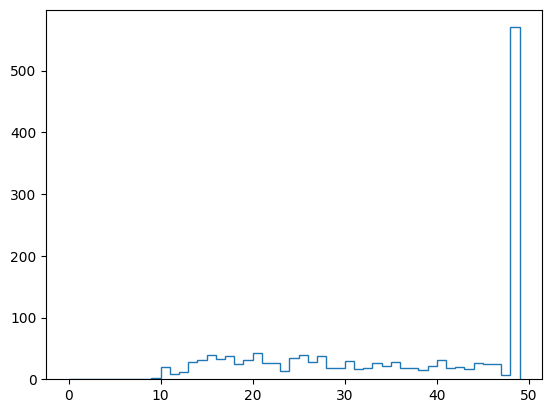

In [ ]:
all_len = []
# for clip_text, target, m_tokens_len in train_loader:
#     for clip_text, target, m_tokens_len in train_loader:
for word_embeddings, pos_one_hots, clip_text, sent_len, pose, m_tokens_len, token, name in val_loader:
    all_len.append(m_tokens_len)
all_len
a = (torch.cat(all_len)/4).numpy()
counts, bins = np.histogram(a, bins = np.arange(50))
plt.stairs(counts, bins)
counts, bins